In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx
import networkx.convert_matrix as nx
import pyvis
import graphviz
from pyvis.network import Network
import pyvis.network as net
import pydot
import random
import time
# https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7
# https://github.com/ewenme/transfers
# https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
# https://github.com/MridulS/pydata-networkx
# https://datapane.com/u/khuyentran1401/reports/63OQaRk/pyvis-visualize-interactive-network-graphs-in-python/

import sys
!{sys.executable} -m pip install pydot

In [2]:
BuLi19 = pd.read_csv("2019_german_bundesliga_1.csv")
PL19 = pd.read_csv("2019_english_premier_league.csv")
SA19 = pd.read_csv("2019_italian_serie_a.csv")
PD19 = pd.read_csv("2019_spanish_primera_division.csv")
L1_19 = pd.read_csv("2019_french_ligue_1.csv")

In [3]:
DF19 = pd.concat([BuLi19, PL19, SA19, PD19, L1_19])

In [4]:
DF19.shape

(4126, 12)

## Clean the Data

In [5]:
def DelCol(DF):
    DF = DF.loc[DF["transfer_movement"]=="in"] # only one direction of transfers should be considered
    DF = DF.loc[DF["fee_cleaned"]>0] # only "real" transfers
    del DF["player_name"]
    del DF["transfer_movement"]
    del DF["age"]
    del DF["position"]
    del DF["fee"]
    del DF["league_name"]
    del DF["transfer_period"]
    del DF["year"]
    del DF["season"]
    return(DF)



In [6]:
DF19 = DelCol(DF19)

In [7]:
BuLi19["colour"] = "red"
print(BuLi19)

             club_name        player_name  age            position  \
0        Bayern Munich    Lucas Hernández   23         Centre-Back   
1        Bayern Munich    Benjamin Pavard   23          Right-Back   
2        Bayern Munich   Michaël Cuisance   20    Central Midfield   
3        Bayern Munich  Philippe Coutinho   27  Attacking Midfield   
4        Bayern Munich       Ivan Perisic   30         Left Winger   
..                 ...                ...  ...                 ...   
585  1.FC Union Berlin        Yunus Malli   27  Attacking Midfield   
586  1.FC Union Berlin      Lennart Moser   20          Goalkeeper   
587  1.FC Union Berlin    Lennard Maloney   20         Centre-Back   
588  1.FC Union Berlin       Nicolai Rapp   23         Centre-Back   
589  1.FC Union Berlin      Lennart Moser   20          Goalkeeper   

    club_involved_name                      fee transfer_movement  \
0      Atlético Madrid                  £72.00m                in   
1        VfB Stuttgar

### Combine multiple transfers between clubs a and b

In [8]:
# now as a function
        
def AddFees(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        if DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0:
            DF_out = DF_out.append(DF.iloc[i])
        else:
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
    return(DF_out)    
        

In [9]:
DF19 = AddFees(DF19)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
DF19

,club_name,club_involved_name,fee_cleaned
0,Bayern Munich,Atlético Madrid,72.00
1,Bayern Munich,VfB Stuttgart,31.50
2,Bayern Munich,Bor. M'gladbach,10.80
3,Bayern Munich,FC Barcelona,7.65
4,Bayern Munich,Inter,4.50
...,...,...,...
681,AS Monaco,AJ Auxerre,9.00
682,AS Monaco,Legia Warszawa,6.30
700,FC Nantes,Standard Liège,3.60
715,Stade Reims,Ajax U21,3.60


## Second Data Set: Undirected
Combine both transfer fees from A to B and B to A as one "transfer volume"

In [11]:
DFun19 =  pd.DataFrame({'club1' : [],
                         "club2":[],
                         "fee_cleaned":[]})

In [12]:
DFun19["club1"] = np.minimum(DF19['club_name'], DF19['club_involved_name']) 
DFun19["club2"] = np.maximum(DF19['club_name'], DF19['club_involved_name']) 

In [13]:
       
def AddFeesUndirected(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        
        if ((DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0) and 
            (DF_out.loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  # Neither direction!
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0)):
            DF_out = DF_out.append(DF.iloc[i])
        
        elif (DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size > 0):
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
        
        else: # add the "reversed" fee to existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
            
    return(DF_out)    
        

In [14]:
DFun19 = AddFeesUndirected(DF19)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Graphs

In [47]:
G = nx.from_pandas_edgelist(DF19, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

In [32]:
# Teams of individual leagues 19/20
BL19_teams = list(set(BuLi19["club_name"])) # Bundesliga
BL19List = pd.Series(BL19_teams)

PL19List = pd.Series(list(set(PL19["club_name"])))
SA19List = pd.Series(list(set(SA19["club_name"])))
PD19List = pd.Series(list(set(PD19["club_name"])))
L119List = pd.Series(list(set(L1_19["club_name"])))




l = ["red", "blue"]
print(len(G.nodes))
Colours = random.choices(l, k=len(G.nodes))

In [17]:
Colours = ["none"]*len(G.nodes)
j = 0
for i in G.nodes:
    if np.sum(BL19List.isin([i])) > 0: # if Bundesliga-Team
        Colours[j] = "red"
    j = j+1

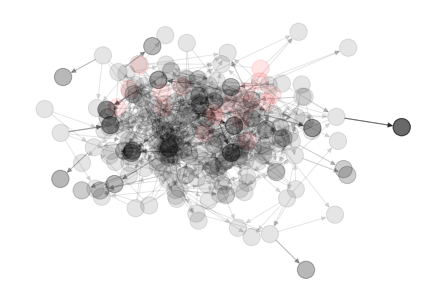

In [18]:
networkx.draw_kamada_kawai(G,node_color = Colours, with_labels=False, alpha=0.1)

In [51]:
def Colour1(node):
    if np.sum(BL19List.isin([node])):
        out = "red"
    elif np.sum(PL19List.isin([node])):
        out = "blue"
    elif np.sum(SA19List.isin([node])):
        out = "green" 
    elif np.sum(PD19List.isin([node])):
        out = "yellow"
    elif np.sum(L119List.isin([node])):
        out = "purple"
    else:
        out = "none"
    return(out)

In [52]:
j = 0
for i in G.nodes:
    Colours[j] = Colour1(i)
    j = j+1

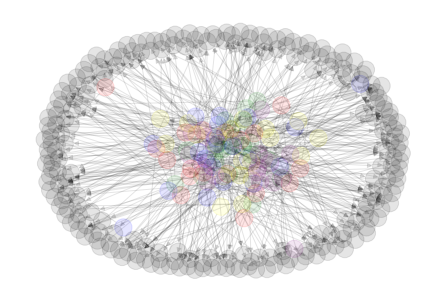

In [53]:
networkx.draw_spring(G,node_color = Colours, with_labels=False, alpha = 0.1)

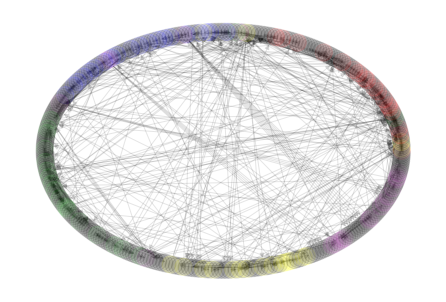

In [59]:
networkx.draw_circular(G,node_color = Colours, with_labels=False, alpha = 0.1)
# one can see blocks of the individual countries + crosslinks

In [20]:
net = Network(notebook=True)
net.from_nx(G)
net.show("Test.html")
# net.save_graph("Test.html")

## Pyvis

In [39]:
g = Network(notebook=True)
G = nx.from_pandas_edgelist(DFun19, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

g.add_nodes(np.array(G.nodes), 
            color = random.choices(["red","grey"], k=len(G.nodes)),
            options = {
                "title":"lel"
            })

In [40]:
for node in G.nodes:
    print(node)

Atlético Madrid
Bayern Munich
VfB Stuttgart
Bor. M'gladbach
FC Barcelona
Inter
Hamburger SV
Borussia Dortmund
TSG Hoffenheim
Bay. Leverkusen
Everton
RB Leipzig
Paris SG
RB Salzburg
Palmeiras U20
AS Roma
Chelsea
Hannover 96
Bayer 04 Leverkusen
Ajax
Borussia Mönchengladbach
FC Schalke 04
Guingamp
Stade Rennais
VfL Wolfsburg
BSC Young Boys
LASK
FC Ingolstadt
Benfica
Eintracht Frankfurt
FC Augsburg
Sporting CP
Red Star
Bor. Dortmund
SV Werder Bremen
TSG 1899 Hoffenheim
FC Copenhagen
Jahn Regensburg
Waasl.-Beveren
Fortuna Düsseldorf
Watford
Hertha BSC
1.FC Nuremberg
Chelsea U23
Liverpool
Feyenoord
1.FSV Mainz 05
West Ham
Espanyol
Monaco
FC Bayern II
Preußen Münster
SC Freiburg
Dijon
F. Düsseldorf
SC Paderborn
Internacional
FC Luzern
FC Dallas
Union Berlin
Nordsjaelland
RSC Anderlecht
1. FC Köln
Montpellier
KAA Gent
PEC Zwolle
Grasshoppers
SC Paderborn 07
1.FC Union Berlin
KRC Genk
1.FC Heidenheim
E. Braunschweig
1.FC Magdeburg
Juventus
Dinamo Zagreb
Vit. Guimarães
River Plate
Sevilla FC
Sam

In [41]:
def Colour(node):
    if np.sum(BL19List.isin([node])):
        out = "rgba(244, 15, 11, 0.33)"
    elif np.sum(PL19List.isin([node])):
        out = "rgba(41, 155, 255, 0.33)"
    elif np.sum(SA19List.isin([node])):
        out = "rgba(41, 255, 77, 0.33)" 
    elif np.sum(PD19List.isin([node])):
        out = "rgba(255, 241, 41, 0.33)"
    elif np.sum(L119List.isin([node])):
        out = "rgba(244, 41, 255, 0.33)"
    else:
        out = "rgba(0, 0, 0, 0.22)"
    return(out)

In [42]:
# https://www.hexcolortool.com/#f40f0b,0.33
for node in G.nodes:
    g.add_node(str(node), color = Colour(node), #alpha=0.1,
              options = {
              })

In [23]:
#var options = {
# "nodes": {
#    "color": {
#      "border": "rgba(43,124,233,0.46)",
#      "background": "rgba(90,65,252,0.51)"
#    }
#  },
#  "edges": {
#    "color": {
#      "inherit": true
#    },
#    "smooth": false
#  },
#  "physics": {
# "enabled": false,
#    "repulsion": {
#     "springLength": 500
#   },
#    "minVelocity": 0.75,
#    "solver": "repulsion"
#  }
#}

In [24]:
#g.add_edges(DF19["club_name"],DF19["club_involved_name"], value =DF19["fee_cleaned"])

In [43]:
for i in range(DFun19.shape[0]):
    g.add_edge(DFun19["club_name"].iloc[i], 
              DFun19["club_involved_name"].iloc[i],
              value=DFun19["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })


In [44]:
g.show("Test.html")

In [27]:
g.save_graph("Test2.html")

In [28]:
DF19.shape[0]

619

In [87]:
DFun19

,club_name,club_involved_name,fee_cleaned
0,Bayern Munich,Atlético Madrid,72.00
1,Bayern Munich,VfB Stuttgart,31.50
2,Bayern Munich,Bor. M'gladbach,10.80
3,Bayern Munich,FC Barcelona,7.65
4,Bayern Munich,Inter,4.50
...,...,...,...
681,AS Monaco,AJ Auxerre,9.00
682,AS Monaco,Legia Warszawa,6.30
700,FC Nantes,Standard Liège,3.60
715,Stade Reims,Ajax U21,3.60


## Analysis

In [71]:
G_undir = nx.from_pandas_edgelist(DFun19, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

#### Small World

In [96]:
## Small world

# random reference graph
#G_ref = networkx.algorithms.smallworld.random_reference(G_undir, seed = 10)
#DFcon19 = DFun19.iloc[DFun19["club_name"]!="SC Paderborn 07"]
#DFcon19 = DFcon19.iloc[DFcon19["club_involved_name"]!="SC Paderborn 07"]

DFcon19 = DFun19.drop(DFun19[ DFun19['club_name'] == "SC Paderborn 07" ].index)
DFcon19 = DFcon19.drop(DFcon19[ DFcon19['club_involved_name'] == "SC Paderborn 07" ].index)

#networkx.algorithms.smallworld.sigma(G_undir,niter=10, seed=10)

In [97]:
DFcon19

,club_name,club_involved_name,fee_cleaned
0,Bayern Munich,Atlético Madrid,72.00
1,Bayern Munich,VfB Stuttgart,31.50
2,Bayern Munich,Bor. M'gladbach,10.80
3,Bayern Munich,FC Barcelona,7.65
4,Bayern Munich,Inter,4.50
...,...,...,...
681,AS Monaco,AJ Auxerre,9.00
682,AS Monaco,Legia Warszawa,6.30
700,FC Nantes,Standard Liège,3.60
715,Stade Reims,Ajax U21,3.60


In [98]:
G_undirconnected = nx.from_pandas_edgelist(DFcon19, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

In [99]:
# Quick check: plot
nt = Network(notebook=True)
nt.from_nx(G_undirconnected)
nt.show('nx.html')
# Is connected!!

In [104]:

start = time.time()

SW = networkx.algorithms.smallworld.sigma(G_undirconnected,niter=20, seed=10)
print(SW)

end = time.time()
print(end - start)

1.4126266711963913
509.8205089569092


#### Scaling Behaviour

In [83]:
networkx.classes.function.degree_histogram(G_undir)

[0, 140, 42, 26, 23, 22, 27, 10, 13, 6, 7, 4, 6, 2, 3, 1, 1, 1, 2]

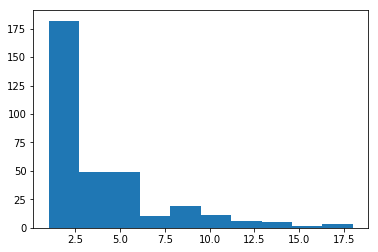

In [84]:
import networkx as nx

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G_undir)

In [72]:
from networkx.algorithms import approximation

approximation.average_clustering(G_undir, trials=1000, seed=10)

0.024

In [65]:
networkx.algorithms.approximation.connectivity.all_pairs_node_connectivity(G_undir)

{'Bayern Munich': {'Atlético Madrid': 1,
  'VfB Stuttgart': 9,
  "Bor. M'gladbach": 5,
  'FC Barcelona': 3,
  'Inter': 2,
  'Hamburger SV': 6,
  'FC Bayern II': 3,
  'Werder Bremen': 6,
  'Bor. Dortmund': 7,
  'LOSC Lille': 1,
  'Flamengo': 1,
  'Fiorentina': 1,
  'Career break': 1,
  'Real Madrid': 2,
  'Borussia Dortmund': 10,
  'TSG Hoffenheim': 9,
  'Bay. Leverkusen': 4,
  'Barça U19': 1,
  'B. Dortmund U19': 1,
  'Norwich': 6,
  'Fulham': 2,
  'E. Frankfurt': 4,
  'Willem II': 2,
  'Besiktas': 1,
  'Celtic': 2,
  'Paris SG': 4,
  'Dynamo Moscow': 1,
  'Real Sociedad': 1,
  'Real Zaragoza': 1,
  'Sassuolo': 1,
  'Hertha BSC': 12,
  'Spartak Moscow': 1,
  'Fortuna Sittard': 2,
  'SD Huesca': 2,
  'Chelsea': 3,
  'RB Leipzig': 9,
  'Everton': 3,
  'RB Salzburg': 5,
  'Palmeiras U20': 1,
  'AS Roma': 1,
  'Hannover 96': 9,
  'RB Leipzig U19': 1,
  'PSV Eindhoven': 2,
  'Monaco': 2,
  '1. FC Köln': 11,
  'Göztepe': 1,
  'FC Luzern': 2,
  'Arsenal U23': 2,
  'Bayer 04 Leverkusen': 10,
 

### Directed

In [73]:
G_dir = nx.from_pandas_edgelist(DF19, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.MultiDiGraph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

In [74]:
networkx.algorithms.hierarchy.flow_hierarchy(G_dir)

0.975767366720517